In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import optuna
from tqdm.notebook import tqdm  # tqdm.auto 대신 tqdm.notebook 사용
from optuna.visualization import plot_optimization_history, plot_param_importances
import random
import numpy as np
import json
import os
from sklearn.model_selection import KFold

In [ ]:
# ========================
# 1. 시드 고정 (재현성 확보)
# ========================
def set_seed(seed=42):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(42)

In [ ]:
# ========================
# 2. 데이터 증강 클래스 정의 (가우시안 노이즈 추가)
# ========================
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.1):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

### Data loading & preprocessing

#### Data augmentation (데이터 증강) 처리 추가
- Rotation, Affine Transformation을 통해 데이터 증강하여 *overfitting* 방지, *robustness* 증대, *Generalization* 성능을 기대할 수 있다.

In [2]:
# ========================
# 3. 데이터 로드 및 전처리 (교차 검증 포함)
# ========================
def load_data(batch_size=64):
    transform_train = transforms.Compose([
        transforms.RandomRotation(degrees=10),
        transforms.RandomResizedCrop(
            size=28,
            scale=(0.8, 1.2),
            ratio=(0.9, 1.1)
        ),  # 랜덤 스케일링
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1)
        ),
        transforms.ToTensor(),
        AddGaussianNoise(
            mean=0.,
            std=0.1
        ),  # 가우시안 노이즈 추가 
        transforms.Normalize(
            mean=(0.5,),
            std=(0.5,)
        )
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            mean=(0.5,),
            std=(0.5,)
        )
    ])
    
    # 전체 학습 데이터셋 로드
    full_train_dataset = datasets.MNIST(
        root='./data',
        train=True,
        transform=transform_train,
        download=True
    )
    test_dataset = datasets.MNIST(
        root='./data',
        train=False,
        transform=transform_test,
        download=True
    )
    
    return full_train_dataset, test_dataset

### LeNet5 Modeling
**1 - 1st conv : 커널 사이즈 5x5**
- 입력 : 1채널의 32x32 이미지
- 출력 : 6채널의 28x28 이미지
- *stride=1*은 컨볼루션 연산 시 건너 뛰는 간격으로, 보통 모든 픽셀에 대해 컨볼루션 수행하므로 1로 설정함

**RELU 함수 적용1**

**2 - 1st pool : 커널 사이즈 2x2**
- 입력 : 6채널의 28x28 이미지
- 출력 : 6채널의 14x14 이미지

**3 - 2nd conv : 커널 사이즈 5x5**
- 입력 : 6채널의 14x14 이미지 
- 출력 : 16채널의 10x10 이미지 (padding 없이 5x5 커널을 사용했으므로 상하좌우로 2라인씩 줄어들어 10x10이 됨)
-> 6x14x14에 *16개의 5x5 커널*과 컨볼루션 연산 하면 16x10x10이 됨

**RELU 함수 적용2**

**4 - 2nd pool : 커널 사이즈 2x2**
- 입력 : 16채널의 10x10 이미지
- 출력 : 16채널의 5x5 이미지

**5 - 3rd conv : 커널 사이즈 5x5**
- 입력 : 16채널의 5x5 이미지 
- 출력 : 120채널의 1x1 이미지

**RELU 함수 적용3**

**conv 결과에 Flatten 처리**

**6 - FCL1**
- 입력 : 120 차원 벡터 [[x1, x2, x3, ... ,x120]]
- 출력 : 84 차원 벡터 [[x1, x2, x3, ... ,x84]]

**RELU 함수 적용4**

**7 - FCL2**
- 입력 : 84 차원 벡터 [[x1, x2, x3, ... ,x84]]
- 출력 : 10 차원 벡터 [[x1, x2, x3, ... ,x10]] **-> logit**

---
#### 멀티 채널에서의 컨볼루션 연산 
입력: 32×32x3
필터: 3x5×5, 총 6개.
출력: 28x28x6
하나의 필터는 입력 데이터의 모든 채널(3채널)에 대해 합성곱 연산을 수행한 후, 결과를 합산하여 하나의 피처맵 생성.
6개의 필터가 독립적으로 작동하여 총 6개의 피처맵 생성. 

---
#### Flatten 처리
- Fully Connected Layer를 통과하기 전에 Flatten 처리를 함
- x.view(x.size(0), -1)
- x는 120x1x1의 3차원 텐서이고, x.size(0)는 배치 사이즈를 의미 64
- 64x120 크기의 2차원 텐서로 평탄화 시킴

In [3]:
# ========================
# 4. 모델 정의 (LeNet5)
# ========================
class LeNet5(nn.Module):
    def __init__(self, dropout_rate=0.5):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=1,
            out_channels=6,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.bn1 = nn.BatchNorm2d(
            num_features=6
        )
        self.pool1 = nn.AvgPool2d(
            kernel_size=2,
            stride=2
        )
        self.conv2 = nn.Conv2d(
            in_channels=6,
            out_channels=16,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.bn2 = nn.BatchNorm2d(
            num_features=16
        )
        self.pool2 = nn.AvgPool2d(
            kernel_size=2,
            stride=2
        )
        self.conv3 = nn.Conv2d(
            in_channels=16,
            out_channels=120,
            kernel_size=5,
            stride=1,
            padding=0
        )
        self.fc1 = nn.Linear(
            in_features=120,
            out_features=84
        )
        self.dropout = nn.Dropout(
            p=dropout_rate
        )
        self.fc2 = nn.Linear(
            in_features=84,
            out_features=10
        )

    def forward(self, x):
        x = F.pad(x, (2, 2, 2, 2))  # 입력 이미지를 32x32로 패딩
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool2(x)
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # 플래튼
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# ========================
# 5. 학습 함수 정의
# ========================

In [4]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=5, early_stopping_patience=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device) 

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)

        # 검증 단계
        model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                total_val_loss += loss.item()
        
        avg_val_loss = total_val_loss / len(val_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
        
        # 스케줄러 업데이트 (ReduceLROnPlateau의 경우)
        if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        else:
            scheduler.step()
        
        # 조기 종료 조건 확인
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                break

In [5]:
# ========================
# 6. 평가 함수 정의
# ========================
def evaluate_model_accuracy(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy


In [7]:
# ========================
# 7. 교차 검증 함수 정의
# ========================
def cross_validate(model_class, dataset, k=5, params=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}")
        # 데이터 로더 생성
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
        
        train_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=params['batch_size'],
            sampler=train_subsampler
        )
        val_loader = torch.utils.data.DataLoader(
            dataset,
            batch_size=params['batch_size'],
            sampler=val_subsampler
        )
        
        # 모델 초기화
        model = model_class(dropout_rate=params['dropout_rate']).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
        
        # 학습률 스케줄러 초기화 (ReduceLROnPlateau)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            patience=params['scheduler_patience'],
            factor=params['scheduler_factor'],
            verbose=False
        )
        
        # 모델 학습
        train_model(
            model,
            train_loader,
            val_loader,
            criterion,
            optimizer,
            scheduler,
            num_epochs=params['num_epochs'],
            early_stopping_patience=params['early_stopping_patience']
        )
        
        # 모델 평가
        accuracy = evaluate_model_accuracy(model, val_loader)
        accuracies.append(accuracy)
        print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}%\n")
    
    average_accuracy = sum(accuracies) / len(accuracies)
    print(f"Average Accuracy over {k} folds: {average_accuracy:.2f}%")
    return average_accuracy

[I 2024-12-27 11:27:06,523] A new study created in memory with name: no-name-b7cdc490-27db-4553-8d13-a59df7b0f708
C:\Users\Admin\AppData\Local\Temp\ipykernel_10984\1165575615.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
C:\Users\Admin\AppData\Local\Temp\ipykernel_10984\1165575615.py:8: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.2, 0.5)


Epoch [1/7], Loss: 2.2338
Epoch [2/7], Loss: 1.6289
Epoch [3/7], Loss: 1.2569
Epoch [4/7], Loss: 1.1172
Epoch [5/7], Loss: 1.0190
Epoch [6/7], Loss: 0.9239
Epoch [7/7], Loss: 0.8319


[I 2024-12-27 11:30:06,381] Trial 0 finished with value: 88.52 and parameters: {'learning_rate': 4.3523031064467625e-05, 'batch_size': 256, 'dropout_rate': 0.39460903934704766, 'num_epochs': 7}. Best is trial 0 with value: 88.52.


Epoch [1/10], Loss: 1.4594
Epoch [2/10], Loss: 0.7553
Epoch [3/10], Loss: 0.4828
Epoch [4/10], Loss: 0.3433
Epoch [5/10], Loss: 0.2737
Epoch [6/10], Loss: 0.2304
Epoch [7/10], Loss: 0.2078
Epoch [8/10], Loss: 0.1851
Epoch [9/10], Loss: 0.1749
Epoch [10/10], Loss: 0.1654


[I 2024-12-27 11:34:40,020] Trial 1 finished with value: 97.62 and parameters: {'learning_rate': 0.0001517854182516807, 'batch_size': 128, 'dropout_rate': 0.2291306022294895, 'num_epochs': 10}. Best is trial 1 with value: 97.62.


Epoch [1/15], Loss: 2.3008
Epoch [2/15], Loss: 2.2324
Epoch [3/15], Loss: 1.9735
Epoch [4/15], Loss: 1.6458
Epoch [5/15], Loss: 1.4287
Epoch [6/15], Loss: 1.2982
Epoch [7/15], Loss: 1.2176
Epoch [8/15], Loss: 1.1519
Epoch [9/15], Loss: 1.1028
Epoch [10/15], Loss: 1.0605
Epoch [11/15], Loss: 1.0219
Epoch [12/15], Loss: 0.9778
Epoch [13/15], Loss: 0.9360
Epoch [14/15], Loss: 0.8980
Epoch [15/15], Loss: 0.8594


[I 2024-12-27 11:41:44,248] Trial 2 finished with value: 88.72 and parameters: {'learning_rate': 1.2055237638131643e-05, 'batch_size': 128, 'dropout_rate': 0.44837154022584036, 'num_epochs': 15}. Best is trial 1 with value: 97.62.


Epoch [1/8], Loss: 0.5013
Epoch [2/8], Loss: 0.1413
Epoch [3/8], Loss: 0.1058
Epoch [4/8], Loss: 0.0910
Epoch [5/8], Loss: 0.0784
Epoch [6/8], Loss: 0.0705
Epoch [7/8], Loss: 0.0632
Epoch [8/8], Loss: 0.0613


[I 2024-12-27 11:44:53,994] Trial 3 finished with value: 99.2 and parameters: {'learning_rate': 0.005179258795539069, 'batch_size': 256, 'dropout_rate': 0.2497288713272615, 'num_epochs': 8}. Best is trial 3 with value: 99.2.


Epoch [1/10], Loss: 0.6506
Epoch [2/10], Loss: 0.1726
Epoch [3/10], Loss: 0.1278
Epoch [4/10], Loss: 0.1051
Epoch [5/10], Loss: 0.0880
Epoch [6/10], Loss: 0.0833
Epoch [7/10], Loss: 0.0734
Epoch [8/10], Loss: 0.0704
Epoch [9/10], Loss: 0.0617
Epoch [10/10], Loss: 0.0621


[I 2024-12-27 11:49:08,770] Trial 4 finished with value: 98.91 and parameters: {'learning_rate': 0.002845216908360668, 'batch_size': 256, 'dropout_rate': 0.4912760211258839, 'num_epochs': 10}. Best is trial 3 with value: 99.2.


Epoch [1/12], Loss: 0.2875
Epoch [2/12], Loss: 0.1301
Epoch [3/12], Loss: 0.1083
Epoch [4/12], Loss: 0.1006
Epoch [5/12], Loss: 0.0999
Epoch [6/12], Loss: 0.0998
Epoch [7/12], Loss: 0.0934
Epoch [8/12], Loss: 0.0948
Epoch [9/12], Loss: 0.0974
Epoch [10/12], Loss: 0.0891
Epoch [11/12], Loss: 0.0914
Epoch [12/12], Loss: 0.0870


[I 2024-12-27 11:54:34,616] Trial 5 finished with value: 98.58 and parameters: {'learning_rate': 0.009517355632102839, 'batch_size': 64, 'dropout_rate': 0.3080505307547531, 'num_epochs': 12}. Best is trial 3 with value: 99.2.


Epoch [1/12], Loss: 1.4916
Epoch [2/12], Loss: 0.6907
Epoch [3/12], Loss: 0.3520
Epoch [4/12], Loss: 0.2597
Epoch [5/12], Loss: 0.2129
Epoch [6/12], Loss: 0.1896
Epoch [7/12], Loss: 0.1693
Epoch [8/12], Loss: 0.1557
Epoch [9/12], Loss: 0.1469
Epoch [10/12], Loss: 0.1368
Epoch [11/12], Loss: 0.1300
Epoch [12/12], Loss: 0.1244


[I 2024-12-27 11:59:33,554] Trial 6 finished with value: 98.03 and parameters: {'learning_rate': 0.00030893735477430164, 'batch_size': 256, 'dropout_rate': 0.4543683086111921, 'num_epochs': 12}. Best is trial 3 with value: 99.2.


Epoch [1/7], Loss: 1.9925
Epoch [2/7], Loss: 1.2261
Epoch [3/7], Loss: 1.0557
Epoch [4/7], Loss: 0.9303
Epoch [5/7], Loss: 0.8030
Epoch [6/7], Loss: 0.6752
Epoch [7/7], Loss: 0.5621


[I 2024-12-27 12:02:17,196] Trial 7 finished with value: 92.15 and parameters: {'learning_rate': 9.283242308523981e-05, 'batch_size': 256, 'dropout_rate': 0.30120597524102366, 'num_epochs': 7}. Best is trial 3 with value: 99.2.


Epoch [1/16], Loss: 1.9973
Epoch [2/16], Loss: 1.2823
Epoch [3/16], Loss: 1.1315
Epoch [4/16], Loss: 1.0426
Epoch [5/16], Loss: 0.9436
Epoch [6/16], Loss: 0.8450
Epoch [7/16], Loss: 0.7268
Epoch [8/16], Loss: 0.6155
Epoch [9/16], Loss: 0.5238
Epoch [10/16], Loss: 0.4570
Epoch [11/16], Loss: 0.4091
Epoch [12/16], Loss: 0.3700
Epoch [13/16], Loss: 0.3421
Epoch [14/16], Loss: 0.3177
Epoch [15/16], Loss: 0.3032
Epoch [16/16], Loss: 0.2834


[I 2024-12-27 12:08:55,117] Trial 8 finished with value: 96.02 and parameters: {'learning_rate': 2.8109683593152463e-05, 'batch_size': 64, 'dropout_rate': 0.36001066716409547, 'num_epochs': 16}. Best is trial 3 with value: 99.2.


Epoch [1/18], Loss: 2.1974
Epoch [2/18], Loss: 1.4751
Epoch [3/18], Loss: 1.1622
Epoch [4/18], Loss: 1.0062
Epoch [5/18], Loss: 0.8670
Epoch [6/18], Loss: 0.7315
Epoch [7/18], Loss: 0.6022
Epoch [8/18], Loss: 0.5093
Epoch [9/18], Loss: 0.4427
Epoch [10/18], Loss: 0.3949
Epoch [11/18], Loss: 0.3558
Epoch [12/18], Loss: 0.3268
Epoch [13/18], Loss: 0.3051
Epoch [14/18], Loss: 0.2782
Epoch [15/18], Loss: 0.2652
Epoch [16/18], Loss: 0.2506
Epoch [17/18], Loss: 0.2360
Epoch [18/18], Loss: 0.2286


[I 2024-12-27 12:15:51,392] Trial 9 finished with value: 96.92 and parameters: {'learning_rate': 6.287835780694528e-05, 'batch_size': 256, 'dropout_rate': 0.4963563954992604, 'num_epochs': 18}. Best is trial 3 with value: 99.2.


Epoch [1/5], Loss: 0.6458
Epoch [2/5], Loss: 0.1912
Epoch [3/5], Loss: 0.1420
Epoch [4/5], Loss: 0.1158
Epoch [5/5], Loss: 0.0993


[I 2024-12-27 12:17:52,629] Trial 10 finished with value: 98.0 and parameters: {'learning_rate': 0.0012608663449258305, 'batch_size': 128, 'dropout_rate': 0.2046192583855648, 'num_epochs': 5}. Best is trial 3 with value: 99.2.


Epoch [1/9], Loss: 0.5181
Epoch [2/9], Loss: 0.1431
Epoch [3/9], Loss: 0.1116
Epoch [4/9], Loss: 0.0894
Epoch [5/9], Loss: 0.0767
Epoch [6/9], Loss: 0.0694
Epoch [7/9], Loss: 0.0629
Epoch [8/9], Loss: 0.0588
Epoch [9/9], Loss: 0.0599


[I 2024-12-27 12:21:13,166] Trial 11 finished with value: 99.01 and parameters: {'learning_rate': 0.004164080628099385, 'batch_size': 256, 'dropout_rate': 0.27175821782286164, 'num_epochs': 9}. Best is trial 3 with value: 99.2.


Epoch [1/9], Loss: 0.7497
Epoch [2/9], Loss: 0.2180
Epoch [3/9], Loss: 0.1483
Epoch [4/9], Loss: 0.1223
Epoch [5/9], Loss: 0.1038
Epoch [6/9], Loss: 0.0899
Epoch [7/9], Loss: 0.0844
Epoch [8/9], Loss: 0.0739
Epoch [9/9], Loss: 0.0701


[I 2024-12-27 12:25:03,668] Trial 12 finished with value: 98.96 and parameters: {'learning_rate': 0.0014614501168060989, 'batch_size': 256, 'dropout_rate': 0.26325610745195255, 'num_epochs': 9}. Best is trial 3 with value: 99.2.


Epoch [1/7], Loss: 0.3817
Epoch [2/7], Loss: 0.1123
Epoch [3/7], Loss: 0.0887
Epoch [4/7], Loss: 0.0806
Epoch [5/7], Loss: 0.0688
Epoch [6/7], Loss: 0.0640
Epoch [7/7], Loss: 0.0633


[I 2024-12-27 12:27:46,863] Trial 13 finished with value: 98.7 and parameters: {'learning_rate': 0.00961442978065145, 'batch_size': 256, 'dropout_rate': 0.271857577796197, 'num_epochs': 7}. Best is trial 3 with value: 99.2.


Epoch [1/14], Loss: 0.6357
Epoch [2/14], Loss: 0.1858
Epoch [3/14], Loss: 0.1372
Epoch [4/14], Loss: 0.1131
Epoch [5/14], Loss: 0.0956
Epoch [6/14], Loss: 0.0800
Epoch [7/14], Loss: 0.0755
Epoch [8/14], Loss: 0.0705
Epoch [9/14], Loss: 0.0650
Epoch [10/14], Loss: 0.0626
Epoch [11/14], Loss: 0.0581
Epoch [12/14], Loss: 0.0559
Epoch [13/14], Loss: 0.0537
Epoch [14/14], Loss: 0.0510


[I 2024-12-27 12:33:11,959] Trial 14 finished with value: 99.12 and parameters: {'learning_rate': 0.0031422795753992647, 'batch_size': 256, 'dropout_rate': 0.2479430958664263, 'num_epochs': 14}. Best is trial 3 with value: 99.2.


Epoch [1/14], Loss: 0.6874
Epoch [2/14], Loss: 0.2001
Epoch [3/14], Loss: 0.1459
Epoch [4/14], Loss: 0.1239
Epoch [5/14], Loss: 0.1052
Epoch [6/14], Loss: 0.0917
Epoch [7/14], Loss: 0.0857
Epoch [8/14], Loss: 0.0783
Epoch [9/14], Loss: 0.0742
Epoch [10/14], Loss: 0.0676
Epoch [11/14], Loss: 0.0629
Epoch [12/14], Loss: 0.0592
Epoch [13/14], Loss: 0.0570
Epoch [14/14], Loss: 0.0539


[I 2024-12-27 12:38:54,694] Trial 15 finished with value: 99.02 and parameters: {'learning_rate': 0.0006528379527849571, 'batch_size': 64, 'dropout_rate': 0.3381753702896116, 'num_epochs': 14}. Best is trial 3 with value: 99.2.


Epoch [1/18], Loss: 0.6208
Epoch [2/18], Loss: 0.1710
Epoch [3/18], Loss: 0.1193
Epoch [4/18], Loss: 0.0973
Epoch [5/18], Loss: 0.0845
Epoch [6/18], Loss: 0.0761
Epoch [7/18], Loss: 0.0665
Epoch [8/18], Loss: 0.0621
Epoch [9/18], Loss: 0.0597
Epoch [10/18], Loss: 0.0541
Epoch [11/18], Loss: 0.0529
Epoch [12/18], Loss: 0.0480
Epoch [13/18], Loss: 0.0456
Epoch [14/18], Loss: 0.0460
Epoch [15/18], Loss: 0.0458
Epoch [16/18], Loss: 0.0427
Epoch [17/18], Loss: 0.0397
Epoch [18/18], Loss: 0.0423


[I 2024-12-27 12:45:34,743] Trial 16 finished with value: 99.28 and parameters: {'learning_rate': 0.0029079897364446237, 'batch_size': 256, 'dropout_rate': 0.2354694644424466, 'num_epochs': 18}. Best is trial 16 with value: 99.28.


Epoch [1/20], Loss: 1.3519
Epoch [2/20], Loss: 0.5268
Epoch [3/20], Loss: 0.3324
Epoch [4/20], Loss: 0.2572
Epoch [5/20], Loss: 0.2096
Epoch [6/20], Loss: 0.1808
Epoch [7/20], Loss: 0.1649
Epoch [8/20], Loss: 0.1543
Epoch [9/20], Loss: 0.1397
Epoch [10/20], Loss: 0.1297
Epoch [11/20], Loss: 0.1238
Epoch [12/20], Loss: 0.1162
Epoch [13/20], Loss: 0.1061
Epoch [14/20], Loss: 0.1022
Epoch [15/20], Loss: 0.1042
Epoch [16/20], Loss: 0.0956
Epoch [17/20], Loss: 0.0927
Epoch [18/20], Loss: 0.0908
Epoch [19/20], Loss: 0.0875
Epoch [20/20], Loss: 0.0866


[I 2024-12-27 12:53:11,521] Trial 17 finished with value: 98.44 and parameters: {'learning_rate': 0.00040361844541395123, 'batch_size': 256, 'dropout_rate': 0.2036298054860092, 'num_epochs': 20}. Best is trial 16 with value: 99.28.


Epoch [1/20], Loss: 0.4278
Epoch [2/20], Loss: 0.1411
Epoch [3/20], Loss: 0.1046
Epoch [4/20], Loss: 0.0877
Epoch [5/20], Loss: 0.0751
Epoch [6/20], Loss: 0.0658
Epoch [7/20], Loss: 0.0622
Epoch [8/20], Loss: 0.0567
Epoch [9/20], Loss: 0.0542
Epoch [10/20], Loss: 0.0496
Epoch [11/20], Loss: 0.0478
Epoch [12/20], Loss: 0.0482
Epoch [13/20], Loss: 0.0451
Epoch [14/20], Loss: 0.0429
Epoch [15/20], Loss: 0.0402
Epoch [16/20], Loss: 0.0421
Epoch [17/20], Loss: 0.0376
Epoch [18/20], Loss: 0.0380
Epoch [19/20], Loss: 0.0363
Epoch [20/20], Loss: 0.0362


[I 2024-12-27 13:02:07,703] Trial 18 finished with value: 99.14 and parameters: {'learning_rate': 0.0013085347594247534, 'batch_size': 64, 'dropout_rate': 0.3191341577172339, 'num_epochs': 20}. Best is trial 16 with value: 99.28.


Epoch [1/17], Loss: 0.4191
Epoch [2/17], Loss: 0.1230
Epoch [3/17], Loss: 0.0943
Epoch [4/17], Loss: 0.0819
Epoch [5/17], Loss: 0.0745
Epoch [6/17], Loss: 0.0689
Epoch [7/17], Loss: 0.0647
Epoch [8/17], Loss: 0.0623
Epoch [9/17], Loss: 0.0670
Epoch [10/17], Loss: 0.0602
Epoch [11/17], Loss: 0.0585
Epoch [12/17], Loss: 0.0562
Epoch [13/17], Loss: 0.0567
Epoch [14/17], Loss: 0.0526
Epoch [15/17], Loss: 0.0508
Epoch [16/17], Loss: 0.0514
Epoch [17/17], Loss: 0.0511


[I 2024-12-27 13:09:14,655] Trial 19 finished with value: 98.96 and parameters: {'learning_rate': 0.005000055388406933, 'batch_size': 128, 'dropout_rate': 0.3727698859983155, 'num_epochs': 17}. Best is trial 16 with value: 99.28.


Best trial:
  Accuracy: 99.28%
  Params: 
    learning_rate: 0.0029079897364446237
    batch_size: 256
    dropout_rate: 0.2354694644424466
    num_epochs: 18
Epoch [1/18], Loss: 0.6476
Epoch [2/18], Loss: 0.1703
Epoch [3/18], Loss: 0.1145
Epoch [4/18], Loss: 0.0926
Epoch [5/18], Loss: 0.0798
Epoch [6/18], Loss: 0.0709
Epoch [7/18], Loss: 0.0661
Epoch [8/18], Loss: 0.0586
Epoch [9/18], Loss: 0.0521
Epoch [10/18], Loss: 0.0517
Epoch [11/18], Loss: 0.0508
Epoch [12/18], Loss: 0.0476
Epoch [13/18], Loss: 0.0486
Epoch [14/18], Loss: 0.0467
Epoch [15/18], Loss: 0.0433
Epoch [16/18], Loss: 0.0437
Epoch [17/18], Loss: 0.0432
Epoch [18/18], Loss: 0.0395
Final Accuracy with Best Params: 99.13%


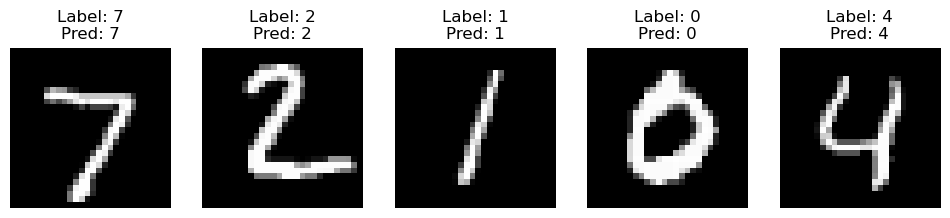

In [8]:
# ========================
# 8. Optuna를 사용한 하이퍼파라미터 튜닝 (교차 검증 포함)
# ========================
def objective(trial):
    try:
        # 하이퍼파라미터 제안
        learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        batch_size = trial.suggest_categorical('batch_size', [64, 128, 256])
        dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
        num_epochs = trial.suggest_int('num_epochs', 5, 20)
        early_stopping_patience = trial.suggest_int('early_stopping_patience', 3, 10)
        
        # ReduceLROnPlateau의 하이퍼파라미터 제안
        scheduler_patience = trial.suggest_int('scheduler_patience', 2, 5)
        scheduler_factor = trial.suggest_float('scheduler_factor', 0.1, 0.5, step=0.1)
        
        # 데이터 로드
        full_train_dataset, _ = load_data(batch_size)
        
        # 교차 검증 수행
        params = {
            'learning_rate': learning_rate,
            'batch_size': batch_size,
            'dropout_rate': dropout_rate,
            'num_epochs': num_epochs,
            'early_stopping_patience': early_stopping_patience,
            'scheduler_patience': scheduler_patience,
            'scheduler_factor': scheduler_factor
        }
        
        average_accuracy = cross_validate(LeNet5, full_train_dataset, k=5, params=params)
        
        return average_accuracy
    except Exception as e:
        print(f"An error occurred during trial: {e}")
        return 0  # 에러 발생 시 최소 정확도로 반환

In [ ]:
# ========================
# 9. Optuna 스터디 생성 및 최적화 실행
# ========================
def run_optuna_study(n_trials=20):
    # Optuna 스터디 생성 (목표는 최대화, 즉 정확도 최대화)
    study = optuna.create_study(direction='maximize')
    
    # 최적화 실행
    study.optimize(objective, n_trials=n_trials)
    
    # 최적의 하이퍼파라미터 출력
    if study.best_trial is not None:
        print("Best trial:")
        trial = study.best_trial

        print(f"  Accuracy: {trial.value:.2f}%")
        print("  Params: ")
        for key, value in trial.params.items():
            print(f"    {key}: {value}")
        
        # 하이퍼파라미터 저장
        with open('outputs/best_hyperparameters.json', 'w') as f:
            json.dump(trial.params, f, indent=4)
        print("하이퍼파라미터가 'outputs/best_hyperparameters.json' 파일로 저장되었습니다.")
        
        return trial.params, study
    else:
        print("No successful trials found.")
        return None, study

In [ ]:
# ========================
# 10. 모델 저장 및 불러오기
# ========================
def save_model(model, path='outputs/best_lenet5_mnist.pth'):
    torch.save(model.state_dict(), path)
    print(f"모델이 '{path}' 파일로 저장되었습니다.")

def load_model(path='outputs/best_lenet5_mnist.pth', dropout_rate=0.5):
    model = LeNet5(dropout_rate=dropout_rate)
    model.load_state_dict(torch.load(path))
    model.eval()
    print(f"모델이 '{path}' 파일에서 불러와졌습니다.")
    return model

In [ ]:
# ========================
# 11. 예측 시각화
# ========================
def visualize_predictions(model, test_loader, num_images=5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    data_iter = iter(test_loader)
    images, labels = next(data_iter)
    images, labels = images[:num_images].to(device), labels[:num_images].to(device)

    outputs = model(images)
    _, preds = torch.max(outputs, 1)

    fig, axes = plt.subplots(2, num_images, figsize=(15, 6))

    for idx in range(num_images):
        # 원본 이미지
        ax = axes[0, idx]
        img = images[idx].cpu().squeeze()
        img = img * 0.5 + 0.5  # 정규화 해제
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Label: {labels[idx].item()}')
        ax.axis('off')
        
        # 예측된 이미지
        ax = axes[1, idx]
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pred: {preds[idx].item()}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# ========================
# 12. 메인 함수 정의
# ========================
def main():
    # Optuna 하이퍼파라미터 튜닝 실행
    best_params, study = run_optuna_study(n_trials=20)
    
    if best_params is not None:
        # 데이터 로드
        full_train_dataset, test_dataset = load_data(best_params['batch_size'])
        
        # 전체 학습 데이터 로드
        # Optuna에서 사용한 전체 학습 데이터를 다시 사용하지 않고, 전체 데이터로 다시 학습
        train_loader = torch.utils.data.DataLoader(
            full_train_dataset,
            batch_size=best_params['batch_size'],
            shuffle=True
        )
        test_loader = torch.utils.data.DataLoader(
            test_dataset,
            batch_size=best_params['batch_size'],
            shuffle=False
        )
        
        # 모델 초기화
        best_model = LeNet5(dropout_rate=best_params['dropout_rate'])
        
        # 손실 함수 및 최적화 알고리즘
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
        
        # 학습률 스케줄러 초기화 (ReduceLROnPlateau)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
            mode='min',
            patience=best_params['scheduler_patience'],
            factor=best_params['scheduler_factor'],
            verbose=True
        )
        
        # 모델 학습
        train_model(
            best_model,
            train_loader,
            test_loader,  # 여기서는 검증 데이터를 테스트 데이터로 사용
            criterion,
            optimizer,
            scheduler,
            num_epochs=best_params['num_epochs'],
            early_stopping_patience=best_params['early_stopping_patience']
        )
        
        # 최종 평가
        final_accuracy = evaluate_model_accuracy(best_model, test_loader)
        print(f"Final Accuracy with Best Params: {final_accuracy:.2f}%")
        
        # 예측 시각화
        visualize_predictions(best_model, test_loader, num_images=5)
        
        # 모델 저장
        save_model(best_model, 'outputs/best_lenet5_mnist.pth')
        
        # Optuna 시각화
        fig1 = plot_optimization_history(study)
        fig1.savefig('outputs/optimization_history.png')
        print("Optuna 최적화 히스토리가 'outputs/optimization_history.png'로 저장되었습니다.")
        
        fig2 = plot_param_importances(study)
        fig2.savefig('outputs/param_importances.png')
        print("Optuna 파라미터 중요도가 'outputs/param_importances.png'로 저장되었습니다.")
    else:
        print("최적의 하이퍼파라미터를 찾지 못했습니다.")

In [ ]:
if __name__ == "__main__":
    # 디렉토리 생성
    os.makedirs('outputs', exist_ok=True)
    
    main()